<a href="https://colab.research.google.com/github/yongsa-nut/TU_CN408_GenAI_671/blob/main/Google_Gemini_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Google Gemini Demo

- Materials are based on https://github.com/https-deeplearning-ai/sc-gc-c4-gemini-public

In [ ]:
!pip install --upgrade google-cloud-aiplatform

In [ ]:
!gcloud auth application-default login

In [ ]:
!gcloud auth application-default set-quota-project gen-ai-demo-3 # replace the last one with your project ID

In [ ]:
import base64
import vertexai
from vertexai.generative_models import GenerativeModel, Part, Image

PROJECT_ID = "gen-ai-demo-3"
LOCATION = "us-central1"

vertexai.init(project=PROJECT_ID, location=LOCATION)

def generate(prompt):
    model = GenerativeModel(
        "gemini-1.5-flash-001", # The haiku equivalent
    )
    responses = model.generate_content(
        prompt,
        generation_config={ "max_output_tokens": 8192,
                            "temperature": 0}
    )

    return responses.text

generate("Hello Test")

In [ ]:
model = GenerativeModel("gemini-1.5-pro-001") # The sonnet equivalent

## Streaming output

- `stream=True` processes the response as it being generated.
- With `stream=False`, you have to wait until the entire response has been generated before it can be proccessed and printed.

In [ ]:
response_1 = model.generate_content("Hello Test", stream=True)

In [ ]:
response_1

In [ ]:
for response in response_1:
    print(response)

In [ ]:
response_1 = model.generate_content("Hello, can you tell me more about yourself?", stream=True)
for response in response_1:
  print(response.text)

## Multimodality: Image + Text


- Load a prompt and an image

In [ ]:
# We will be using images from Claude again just for comparison
!git clone https://github.com/anthropics/anthropic-cookbook.git

In [ ]:
image = Image.load_from_file("/content/anthropic-cookbook/images/sunset.jpeg")
display(image)

In [ ]:
prompt = "Please describe what is in this image?"
full_prompt = [image, prompt]
response = model.generate_content(
    full_prompt
)

print(response.text)

In [ ]:
generate(full_prompt)

## Multimodality: Video + Text

- Load a video and a prompt.
- Got the video from the dl.ai github

In [24]:
file_path = "dlai-sc-gemini-bucket/pixel8.mp4"
video_uri = f"gs://{file_path}"
video_url = f"https://storage.googleapis.com/{file_path}"

In [25]:
import IPython

In [26]:
IPython.display.Video(video_url, width=450)

In [27]:
prompt = """Answer the following questions using the video only:
 - What is the main person's profession?
 - What are the main features of the phone highlighted?
 - Which city was this recorded in?
"""

In [28]:
video = Part.from_uri(video_uri, mime_type="video/mp4")
contents_video = [prompt, video]

- The code below will cost a bit too run! Do not run it more than one!!

In [29]:
print(generate(contents_video))

'- The main person is a photographer.\n- The main features of the phone highlighted are the night mode and the video boost.\n- The video was recorded in Tokyo. \n'

## Creating use cases with images
- We will go through a few examples of using Gemini

In [ ]:
# First let download their images
!git clone https://github.com/https-deeplearning-ai/sc-gc-c4-gemini-public.git

### Calcualte price

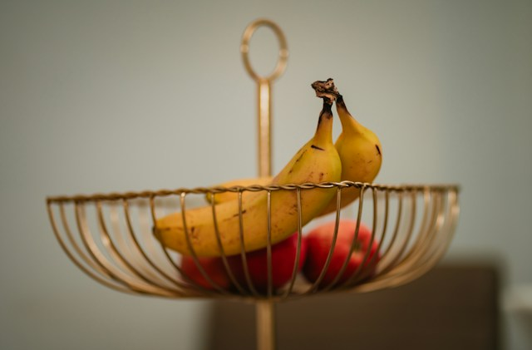

In [32]:
fruit = Image.load_from_file("/content/sc-gc-c4-gemini-public/lesson-4/bowl-fruits.jpg")
display(fruit)

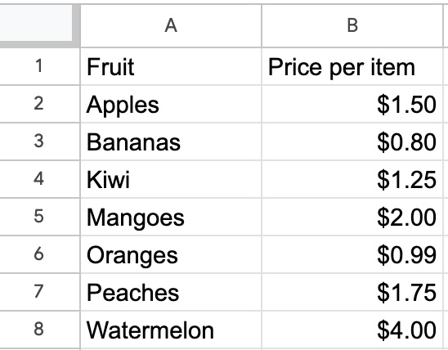

In [33]:
prices = Image.load_from_file("/content/sc-gc-c4-gemini-public/lesson-4/price-list-fruits.jpg")
display(prices)

- We will create a prompt consisting of text and images in a sequence.

In [34]:
instruction_1 = """
I want to make a fruit salad with three bananas, two apples, \
one kiwi, and one orange. This is an image of my bowl of fruits:
"""

instruction_2 = "This is the price list for fruits at my supermarket:"

question = """
Please answer these questions:
- Describe which fruits and how many I have in my fruit bowl on the image?
- Given the fruits in my bowl on the image and the fruit salad recipe, what am I missing?
- Given the fruits I still need to buy, what would be the prices and total cost for these fruits?
"""

contents = [
    instruction_1,
    fruit,
    instruction_2,
    prices,
    question
]

In [36]:
print(generate(contents))

- The image shows two bananas and two apples. 
- You are missing one banana, one kiwi, and one orange.
- The price for one banana is $0.80, one kiwi is $1.25, and one orange is $0.99. The total cost for these fruits is $3.04.


### Your very own Interior Designer!
- We want to furniture (chairs) that are suitable to our room.

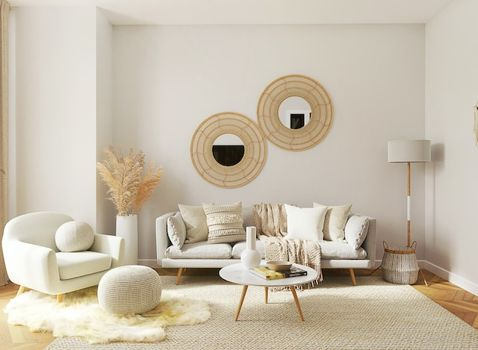

In [37]:
room_image = Image.load_from_file("/content/sc-gc-c4-gemini-public/lesson-4/room.jpg")
display(room_image)

In [40]:
furniture_images_uri = [
    "/content/sc-gc-c4-gemini-public/lesson-4/chair-1.jpg",
    "/content/sc-gc-c4-gemini-public/lesson-4/chair-2.jpg",
    "/content/sc-gc-c4-gemini-public/lesson-4/chair-3.jpg",
    "/content/sc-gc-c4-gemini-public/lesson-4/chair-4.jpg",
]
furniture_images = [Image.load_from_file(uri)
                    for uri in furniture_images_uri]

In [ ]:
for img in furniture_images:
  display(img)

In [44]:
# Our prompt
recommendation_content = [
    "You are an interior designer.",
    "Consider the following chairs:",
    "chair 1:",
    furniture_images[0],
    "chair 2:",
    furniture_images[1],
    "chair 3:",
    furniture_images[2],
    "chair 4:",
    furniture_images[3],
    "room:",
    room_image,
    "For each chair, \
explain whether it would be appropriate for the \
style of the room:",
]

In [ ]:
print(generate(recommendation_content))

### Request Business Expense Reimbursement

In [47]:
receipt_images_uri = [
    '/content/sc-gc-c4-gemini-public/lesson-4/breakfast.jpg',
    '/content/sc-gc-c4-gemini-public/lesson-4/lunch.jpg',
    '/content/sc-gc-c4-gemini-public/lesson-4/diner.jpg',
    '/content/sc-gc-c4-gemini-public/lesson-4/meal-others.jpg',
]
receipt_images = [Image.load_from_file(uri)
                  for uri in receipt_images_uri]

In [ ]:
for img in receipt_images:
  display(img)

In [52]:
INSTRUCTION = "Never make up facts, and if you are not 100% sure, \
be transparent in stating when you are not sure, or do not \
have enough information to answer certain questions or \
fulfill certain requests."

ROLE = "You are an HR professional and an expert in travel expenses."

ASSIGNMENT = """
You are reviewing travel expenses for a business trip.
Please complete the following tasks:
1. Itemize everything on the receipts, including tax and \
total.  This means identifying the cost of individual \
items that add up to the total cost before tax, as well \
as the tax ,such as sales tax, as well as tip.
2. What is the total sales tax paid?  In some cases, \
the total sales tax may be a sum of more than one line \
item of the receipt.
3. For this particular receipt, the employee who is \
adding this business expense purchased the meal with \
a group. The employee only ordered the KFC Bowl. Please \
provide the cost of the employee's order only.  Include \
both the cost before tax, and also estimate the tax \
that is applied to this employee's order.  To do this,\
calculate the fraction of the employee's pre-tax order\
divided by the total pre-tax cost.  This fraction can be \
applied to the total sales tax that you calculated earlier.
4.  Please calculate the amount spent by others, which \
are all the other line items on the receipt.  Please \
provide this sum before tax, and if possible, apply the \
tax for the total cost.
5. Check the expenses against company policy and flag \
if there are issues.
"""

In [49]:
with open("/content/sc-gc-c4-gemini-public/lesson-4/travel-policy.txt", "r") as file:
    policy = file.read()

In [ ]:
print(policy)

In [53]:
receipt_content = [
    INSTRUCTION,
    ROLE,
    "Answer the questions based on the following receipts:"
    "breakfast:",
    receipt_images[0],
    "lunch:",
    receipt_images[1],
    "diner",
    receipt_images[2],
    "meal-others",
    receipt_images[3],
    ASSIGNMENT,
    policy,
]

In [ ]:
print(generate(receipt_content))

## Video use cases

### Digital Marketer

In [56]:
file_path_1 = "dlai-sc-gemini-bucket/vertex-ai-langchain.mp4"
video_uri_1 = f"gs://{file_path_1}"
video_url_1 = f"https://storage.googleapis.com/{file_path_1}"

In [ ]:
IPython.display.Video(video_url_1, width=450)

In [58]:
video_1 = Part.from_uri(video_uri_1, mime_type="video/mp4")

#### Prompting Video
- Structure your prompt(s).
- Be specific with what you want the model to do for you.
- Specify the output format of the response from the model.

In [55]:
role = """
You are a great digital marketer working on a new video.
"""
tasks = """
You will add the video to your website and to do this you
need to complete some tasks. Please make sure your answer
is structured.

Tasks:
- What is the title of the video?
- Write a summary of what is in the video.
- Generate metadata for the video in JSON that includes:\
Title, short description, language, and company.
"""
format_json = "Please output the metadata in JSON"

In [59]:
contents_1 = [video_1, role, tasks]
# contents_1 = [video_1, role, tasks, format_json]

- Running the cell below may take some time and money

In [ ]:
print(generate(contents_1))

### Explaining the Educational Concepts

In [ ]:
file_path_2 = "dlai-sc-gemini-bucket/descending-into-ml.mp4"
video_uri_2 = f"gs://{file_path_2}"
video_url_2 = f"https://storage.googleapis.com/{file_path_2}"

IPython.display.Video(video_url_2, width=450)

In [ ]:
video_2 = Part.from_uri(video_uri_2, mime_type="video/mp4")

- You can even ask the model to answer based on answers of previous questions.
- And to generate programming code based on previous answers.

In [ ]:
prompt = """
Please have a look at the video and answer the following
questions.

Questions:
- Question 1: Which concept is explained in the video?
- Question 2: Based on your answer to Question 1,
can you explain the basic math of this concept?
- Question 3: Can you provide a simple scikit code example
explaining the concept?
"""

In [ ]:
contents_2 = [video_2, prompt]
print(generate(contents_2))

### Extracting Information


In [ ]:
file_path_3 = "dlai-sc-gemini-bucket/google-search.mp4"
video_uri_3 = f"gs://{file_path_3}"
video_url_3 = f"https://storage.googleapis.com/{file_path_3}"

IPython.display.Video(video_url_3, width=450)

In [ ]:
video_ext = Part.from_uri(video_uri_3, mime_type="video/mp4")

In [ ]:
prompt_ext = """
Answer the following questions using the video only.
Present the results in a table with a row for each question
and its answer.
Make sure the table is in markdown format.

Questions:
- What is the most searched sport?
- Who is the most searched scientist?

Format:
- Present the results in a table with a row for each question and its answer.
- Make sure the table is in markdown format.
"""
contents_ext = [video_ext, prompt_ext]

In [ ]:
print(generate(contents_ext))